In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def kernel_rbf(a, b, L): 
    output = -1 * np.ones((a.shape[0], b.shape[0])) 
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            output[i, j] = np.power(np.linalg.norm(a[i, :] - b[j, :], 2), 2)
    return np.exp(- L * output)

In [3]:
class GaussianProcessRegressor: 

    def __init__(self, kernel_L, sigma_sq_process, input_dim):
        self.kernel_L = kernel_L
        self.sigma_sq_process = sigma_sq_process  
        self.input_dim = input_dim

    def load_data(self, x, y):
        n = x.shape[0]
        self.x_vect = np.array([x]).reshape(n, self.input_dim)
        self.y_vect = np.array([y]).reshape(n, 1)
        self.K_matrix_inv = np.linalg.inv(kernel_rbf(self.x_vect, self.x_vect, self.kernel_L) + self.sigma_sq_process * np.eye(n))
    
    def compute(self, x):
        assert x.ndim == 2 and x.shape[1] == self.input_dim, "compute() function: Error in input dimension"
        n = x.shape[0]
        mu = np.zeros(n)
        sigma = np.zeros(n)
        for i in range(n):
            K_star = kernel_rbf(self.x_vect, x[i, :].reshape(1, self.input_dim), self.kernel_L)
            mu[i] = K_star.T @ self.K_matrix_inv @ self.y_vect
            sigma[i] = kernel_rbf(x[i, :].reshape(1, self.input_dim), x[i, :].reshape(1, self.input_dim), self.kernel_L) - K_star.T @ self.K_matrix_inv @ K_star
        return mu, sigma

In [4]:
class HeteroskedasticGaussianProcessRegressor: 

    def __init__(self, kernel_L, input_dim):
        self.kernel_L = kernel_L 
        self.input_dim = input_dim

    def load_data(self, x, y, sigma_sq):
        n = x.shape[0]
        self.x_vect = np.array([x]).reshape(n, self.input_dim)
        self.y_vect = np.array([y]).reshape(n, 1)
        self.K_matrix_inv = np.linalg.inv(kernel_rbf(self.x_vect, self.x_vect, self.kernel_L) + np.diag(sigma_sq.reshape(n, )))

    def compute(self, x):
        assert x.ndim == 2 and x.shape[1] == self.input_dim, "compute() function: Error in input dimension"
        n = x.shape[0]
        mu = np.zeros(n)
        sigma = np.zeros(n)
        for i in range(n):
            K_star = kernel_rbf(self.x_vect, x[i, :].reshape(1, self.input_dim), self.kernel_L)
            mu[i] = K_star.T @ self.K_matrix_inv @ self.y_vect
            sigma[i] = kernel_rbf(np.array([x[i, :]]).reshape(1, self.input_dim), np.array([x[i, :]]).reshape(1, self.input_dim), self.kernel_L) - K_star.T @ self.K_matrix_inv @ K_star
        return mu, sigma

/var/folders/58/jk09dpw90wv_97d9nbc3mnn00000gn/T/ipykernel_58032/337762192.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[i] = K_star.T @ self.K_matrix_inv @ self.y_vect
/var/folders/58/jk09dpw90wv_97d9nbc3mnn00000gn/T/ipykernel_58032/337762192.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma[i] = kernel_rbf(np.array([x[i, :]]).reshape(1, self.input_dim), np.array([x[i, :]]).reshape(1, self.input_dim), self.kernel_L) - K_star.T @ self.K_matrix_inv @ K_star
/var/folders/58/jk09dpw90wv_97d9nbc3mnn00000gn/T/ipykernel_58032/2096061525.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated,

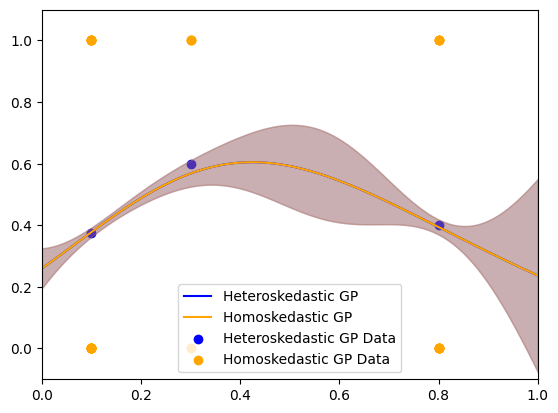

In [9]:
kernel_L = 5
base_sigma_sq = 0.25
x_plt = np.linspace(0, 1, 100) # plot 100 samples

data_x_aggr = np.array([0.1, 0.3, 0.8]).reshape(-1, 1)
data_y_aggr = np.array([6/16, 3/5, 4/10]).reshape(-1, 1)
sigma_sq_aggr = base_sigma_sq * 1 / np.array([16, 5, 10]).reshape(-1, 1)

data_x = np.vstack((0.1 * np.ones((16, 1)), 0.3 * np.ones((5, 1)), 0.8 * np.ones((10, 1))))
data_y = np.vstack((np.ones((6, 1)), np.zeros((10, 1)), np.ones((3, 1)), np.zeros((2, 1)), np.ones((4, 1)), np.zeros((6, 1))))

hetRegressor = HeteroskedasticGaussianProcessRegressor(kernel_L, 1)
hetRegressor.load_data(data_x_aggr, data_y_aggr, sigma_sq_aggr)
y_hat1, y_sigma1 = hetRegressor.compute(x_plt.reshape(-1, 1))
plt.plot(x_plt, y_hat1, color="blue", label="Heteroskedastic GP")
plt.fill_between(x_plt, y_hat1 - y_sigma1, y_hat1 + y_sigma1, color="blue", alpha=0.3)
plt.scatter(data_x_aggr, data_y_aggr, color="blue", label="Heteroskedastic GP Data")

homRegressor = GaussianProcessRegressor(kernel_L, base_sigma_sq, 1)
homRegressor.load_data(data_x, data_y)
y_hat2, y_sigma2 = homRegressor.compute(x_plt.reshape(-1, 1))
plt.plot(x_plt, y_hat2, color="orange", label="Homoskedastic GP")
plt.fill_between(x_plt, y_hat2 - y_sigma2, y_hat2 + y_sigma2, color="orange", alpha=0.3)
plt.scatter(data_x, data_y, color="orange", label="Homoskedastic GP Data")

plt.xlim([0, 1])
plt.ylim([- 0.1, 1.1])
plt.legend()